# Import Library

In [2]:
import numpy as np 
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Data Preprocessing 

### Importing Data Set

In [3]:
dataset = pd.read_csv('monthly_gold_price.csv',header=1)
date = dataset['DATE']
x = date.dropna()
x = pd.to_datetime(x)
x = np.array(x)
x = x[:444]
price = dataset.iloc[:,1:].values
target = price[:,0]=="AVG"
y = price[:,1][target]
y = y[:444]
print(y.shape)
'''
x = dataset.iloc[1:,0].values #x refer to the date columns
x = x.astype("datetime64")
y = dataset.iloc[1:,1].values #y refer to the gold price AM  time
'''
print(x[-1])

(444,)
1986-01-01T00:00:00.000000000


### Handling Missing Data

In [4]:
y = np.array(y, dtype = float).reshape(-1,1)
x = np.array(x).reshape(-1,1)
checkX = np.isnan(x)
checkY = np.isnan(y)
for i in range(checkX.shape[0]):
    if checkX[i,0] == True:
        x[i,0] = x[i-1,0]+ np.datetime64(1, 'd')
for i in range(checkY.shape[0]):
    if checkY[i,0] == True:
        y[i,0] = (y[i-1,0] + y[i-2,0])/2

print(np.count_nonzero(np.isnan(x)))        
print(np.count_nonzero(np.isnan(y)))


0
0


### Split the Data into Training Set and Test Set

In [5]:
test_len = 84

x_test, x_train = x[:test_len,0].reshape(-1,1), x[test_len:,0].reshape(-1,1)
y_test, y_train = y[:test_len,0].reshape(-1,1), y[test_len:,0].reshape(-1,1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
#print(x_train)
#print(x_test)



(360, 1)
(360, 1)
(84, 1)
(84, 1)


### Visualize Data After Preprocessing

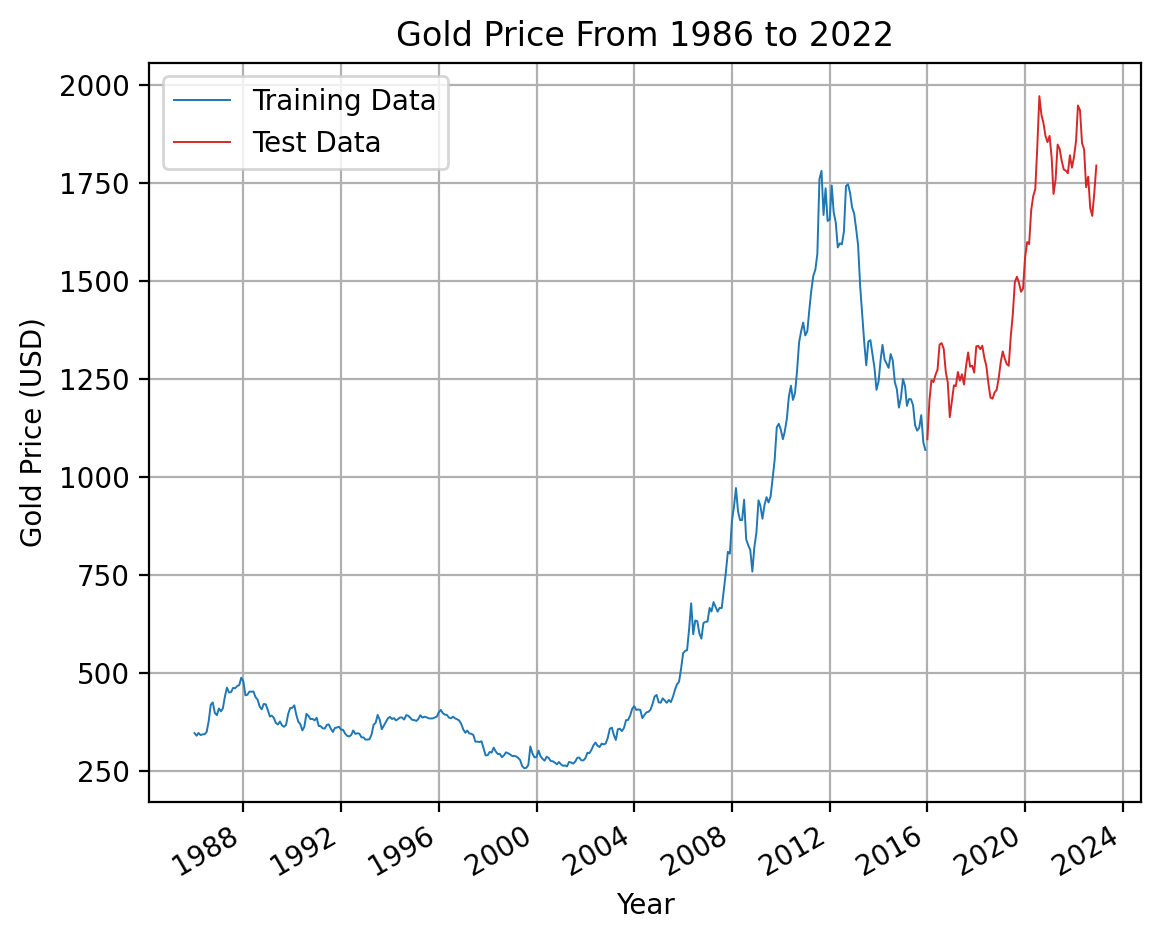

In [6]:
plt.grid()
plt.rcParams["figure.figsize"] = [7.50, 5.0]
plt.rcParams['figure.dpi'] = 1200
plt.rcParams["figure.autolayout"] = True
plt.xticks(rotation=30, ha='right')
plt.plot(x_train, y_train, color = 'C0', label = 'Training Data', linewidth = 0.7 )
plt.plot(x_test, y_test, color = 'C3', label = 'Test Data', linewidth = 0.7)
plt.title('Gold Price From 1986 to 2022')
plt.xlabel('Year')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.show()

# Assessment Criteria

The assesment criteria we are going to use are:  
1. <b> Root Mean Squared Error </b>
   \begin{equation}  
      RMSE = \sqrt{\frac{1}{m}\sum_{i=1}^{m} (Y_{forecast,i}-Y_{actual,i})^2}  
   \end{equation}  
2. <b> Mean Absoulute Percentage Error (MAPE) </b>  
   \begin{equation}  
      MAPE = \frac{1}{m}\sum_{i=1}^{m}\bigg | \frac{(Y_{actual,i}-Y_{forecast,i})}{Y_{actual,i}}\bigg |   
   \end{equation}  
3. <b> Symmetric Mean Absolute Percentage Error (sMAPE) </b>  
   \begin{align*}  
      sMAPE = \frac{1}{m}\sum_{i=1}^{m} \frac{2\cdot|Y_{actual,i}-Y_{forecast,i}|}{|Y_{actual,i}|+|Y_{forecast,i}|}    
   \end{align*} 

In [23]:
def evaluate(y_pred, y_actual):
    rmse = np.sqrt(np.square(y_pred - y_actual).mean())
    mape = np.abs((y_actual-y_pred)/y_actual).mean()
    smape = ((2*np.abs(y_actual-y_pred))/(np.abs(y_actual)+np.abs(y_pred))).mean()
    #print(rmse, mape, smape)
    print('Root Mean Squre error (RMSE)= %f \nMean Absolute Square Error (MAPE) = %f\nSymmetric Mean Absolute Square Error (sMAPE) = %f'%(rmse, mape,smape))

# ARIMA Model

## Augmented Dickey-Fuller test 

In [8]:
from statsmodels.tsa.stattools import adfuller
# Null hypothesis: the model has unit root
resultadf = adfuller(y)
print('ADF Statistic: %f' % resultadf[0])
print('p-value: %f' % resultadf[1])
print('Critical Values:')
for key, value in resultadf[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.614290
p-value: 0.475724
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test 

In [9]:
from statsmodels.tsa.stattools import kpss
#  Null hypothesis: the dataset is stationary
resultkpss = kpss(y)
print('KPSS Statistic: %f' % resultkpss[0])
print('p-value: %f' % resultkpss[1])
print('Lag: ', resultkpss[2])
for key, value in resultkpss[3].items():
  print('\t%s: %.3f' % (key, value))

KPSS Statistic: 2.846682
p-value: 0.010000
Lag:  12
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


c:\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Stationary Test Based on ADF and KPSS


If <b> ADF model rejects the null hypothesis</b> and <b> KPSS do not reject </b>:  <i>Stationarity Exist</i>.  
  
If <b> ADF does not reject the Null Hypothesis </b>while <b>KPSS does reject</b>;    <i>Unit Root Exists</i>.  
  
If <b> ADF and KPSS reject the null hypothesis; Heteroscedasticity</b> is<i> impacting the results</i>.  
  
If <b> ADF and KPSS do not reject the null hypothesis </b> ; <i>Data does not have enough observations</i>.

In [10]:
def stationary(alpha, adf, kpss):
    # Significant  level alpha = 0.05
    if adf <= alpha and kpss > alpha:
        print('The data is Stationary')
    elif adf > alpha and kpss <= alpha:
        print('The data has unit root')
    elif adf <= alpha and kpss <= alpha:
        print('Heteroscedasicity is impacting hte result')
    elif adf > alpha and kpss > alpha:
        print('There is not enough observation')


In [11]:
stationary(0.05, resultadf[1], resultkpss[1])

The data has unit root


The model is <b> has unit root </b>

## Finding the Value of d Parameter

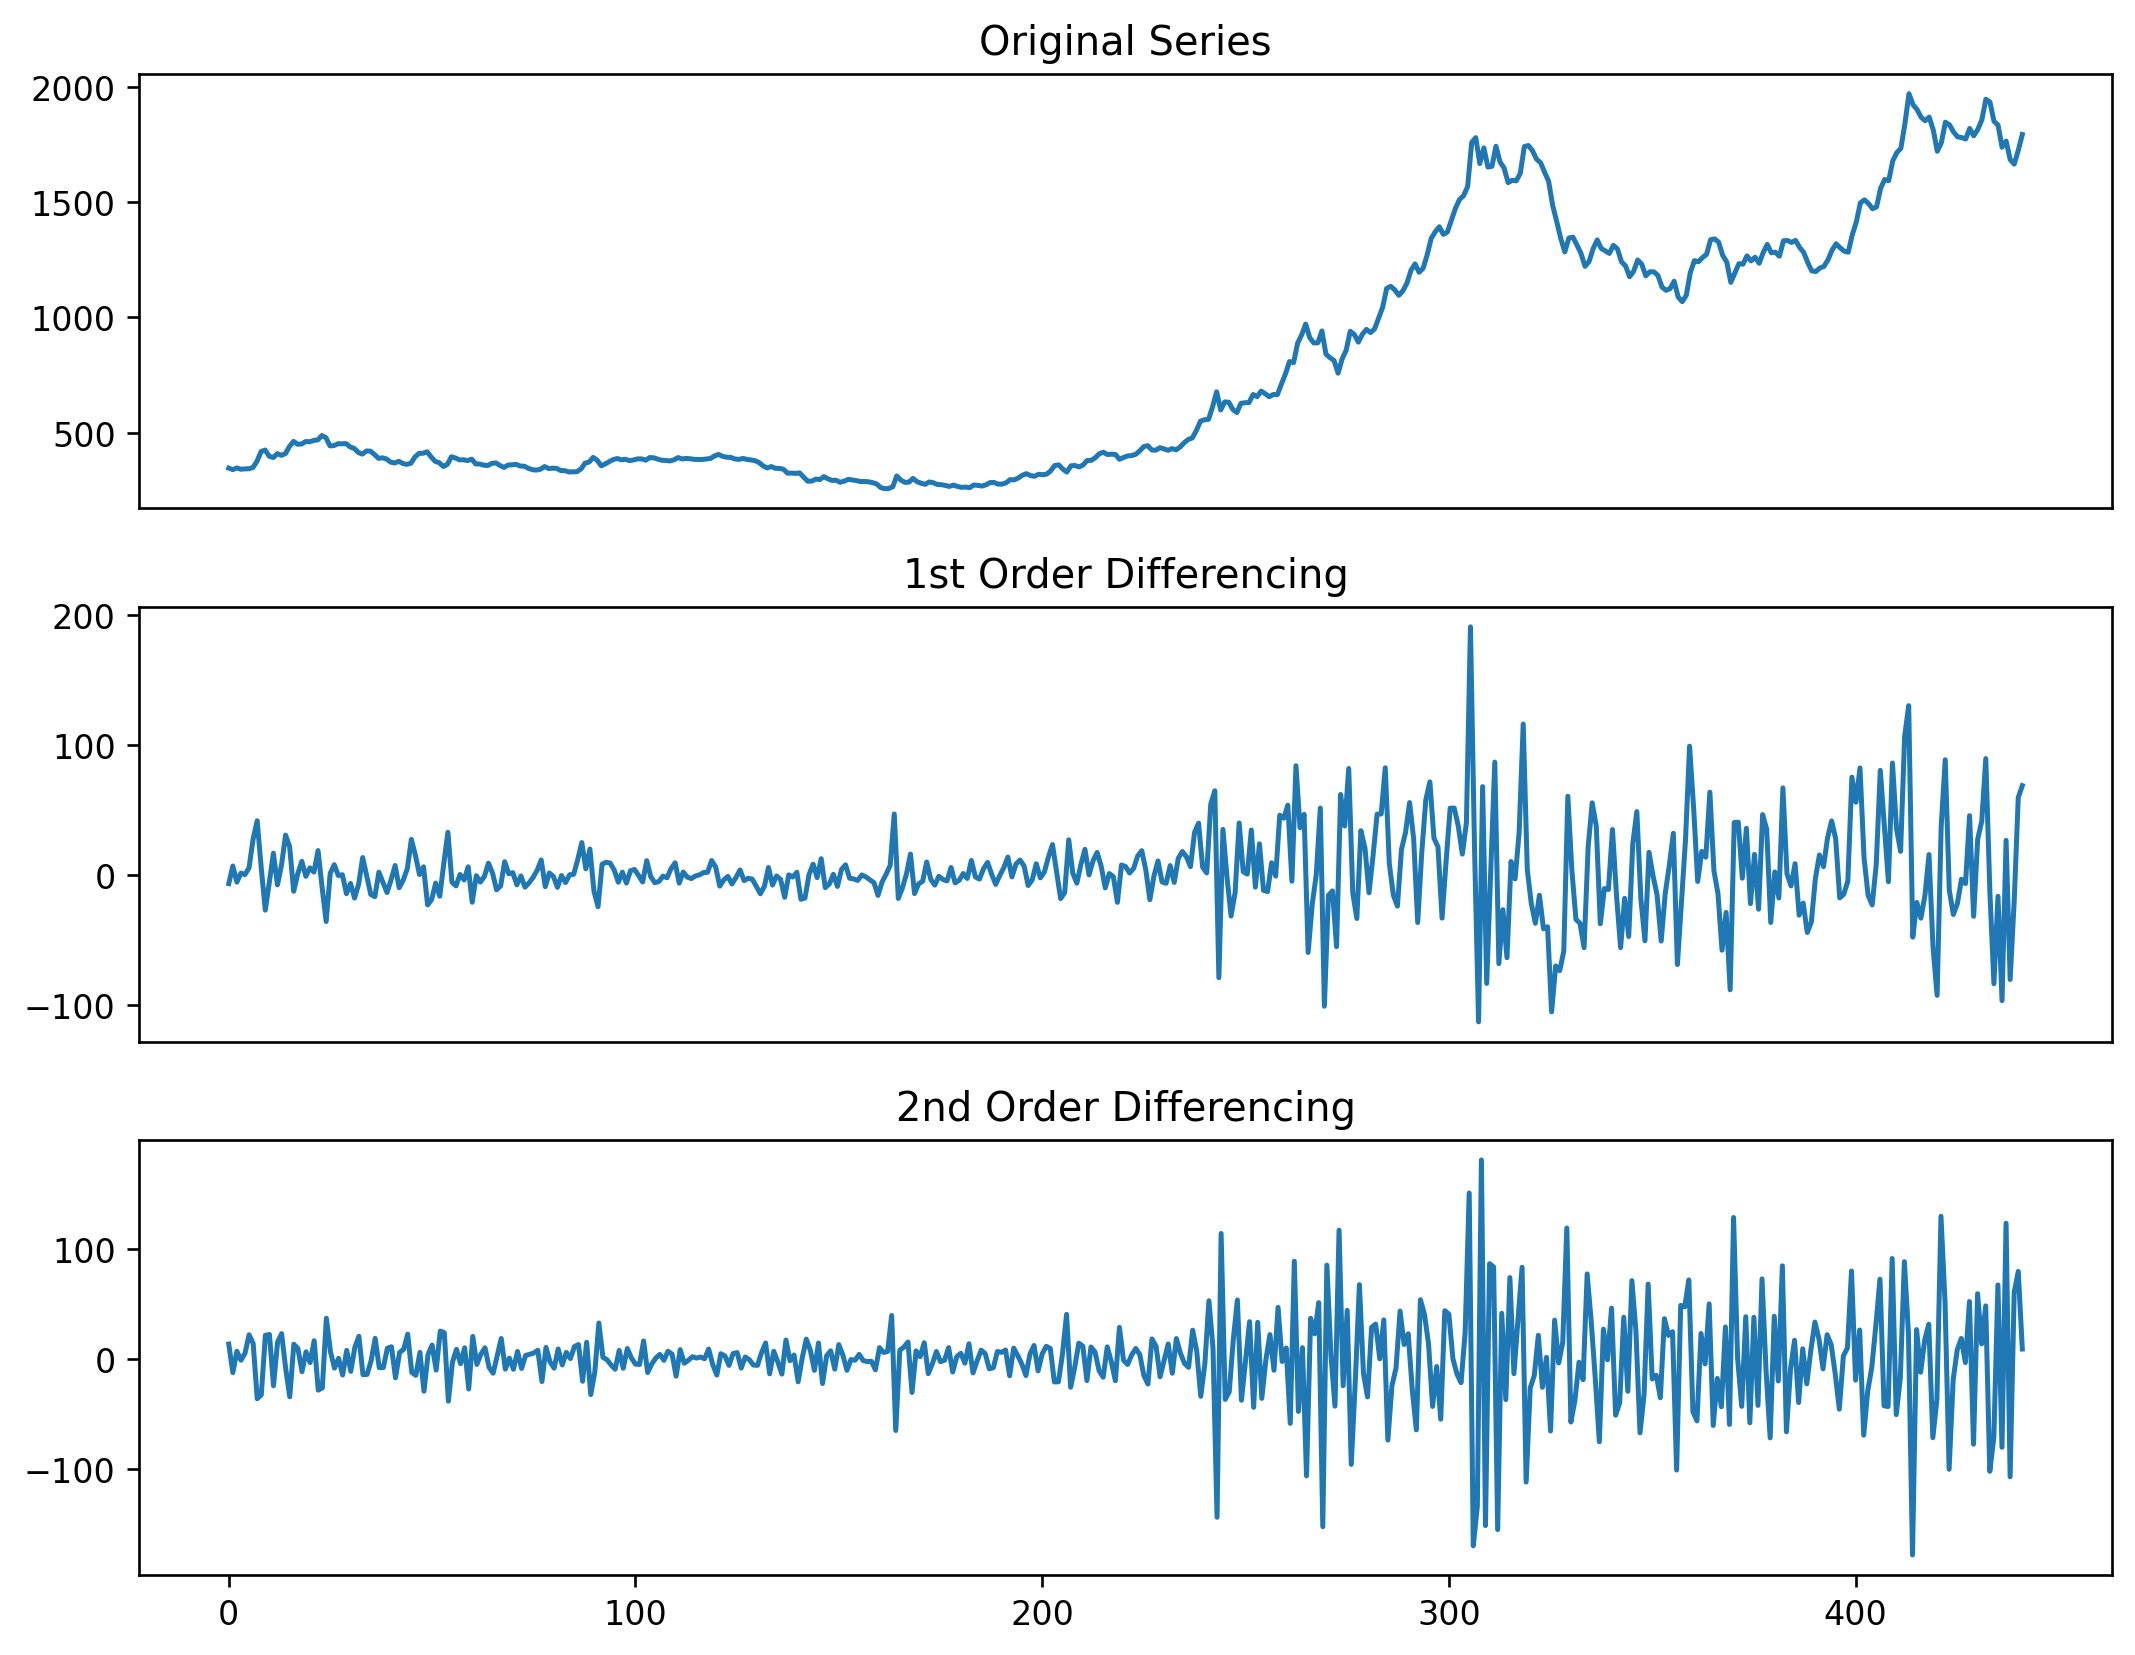

In [12]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
y1 = np.flipud(y)
yd1 = np.ediff1d(y1)
yd2 = np.ediff1d(np.ediff1d(y1))
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(y1); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(yd1); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(yd2); ax3.set_title('2nd Order Differencing')
plt.show()

### Plotting ACF 

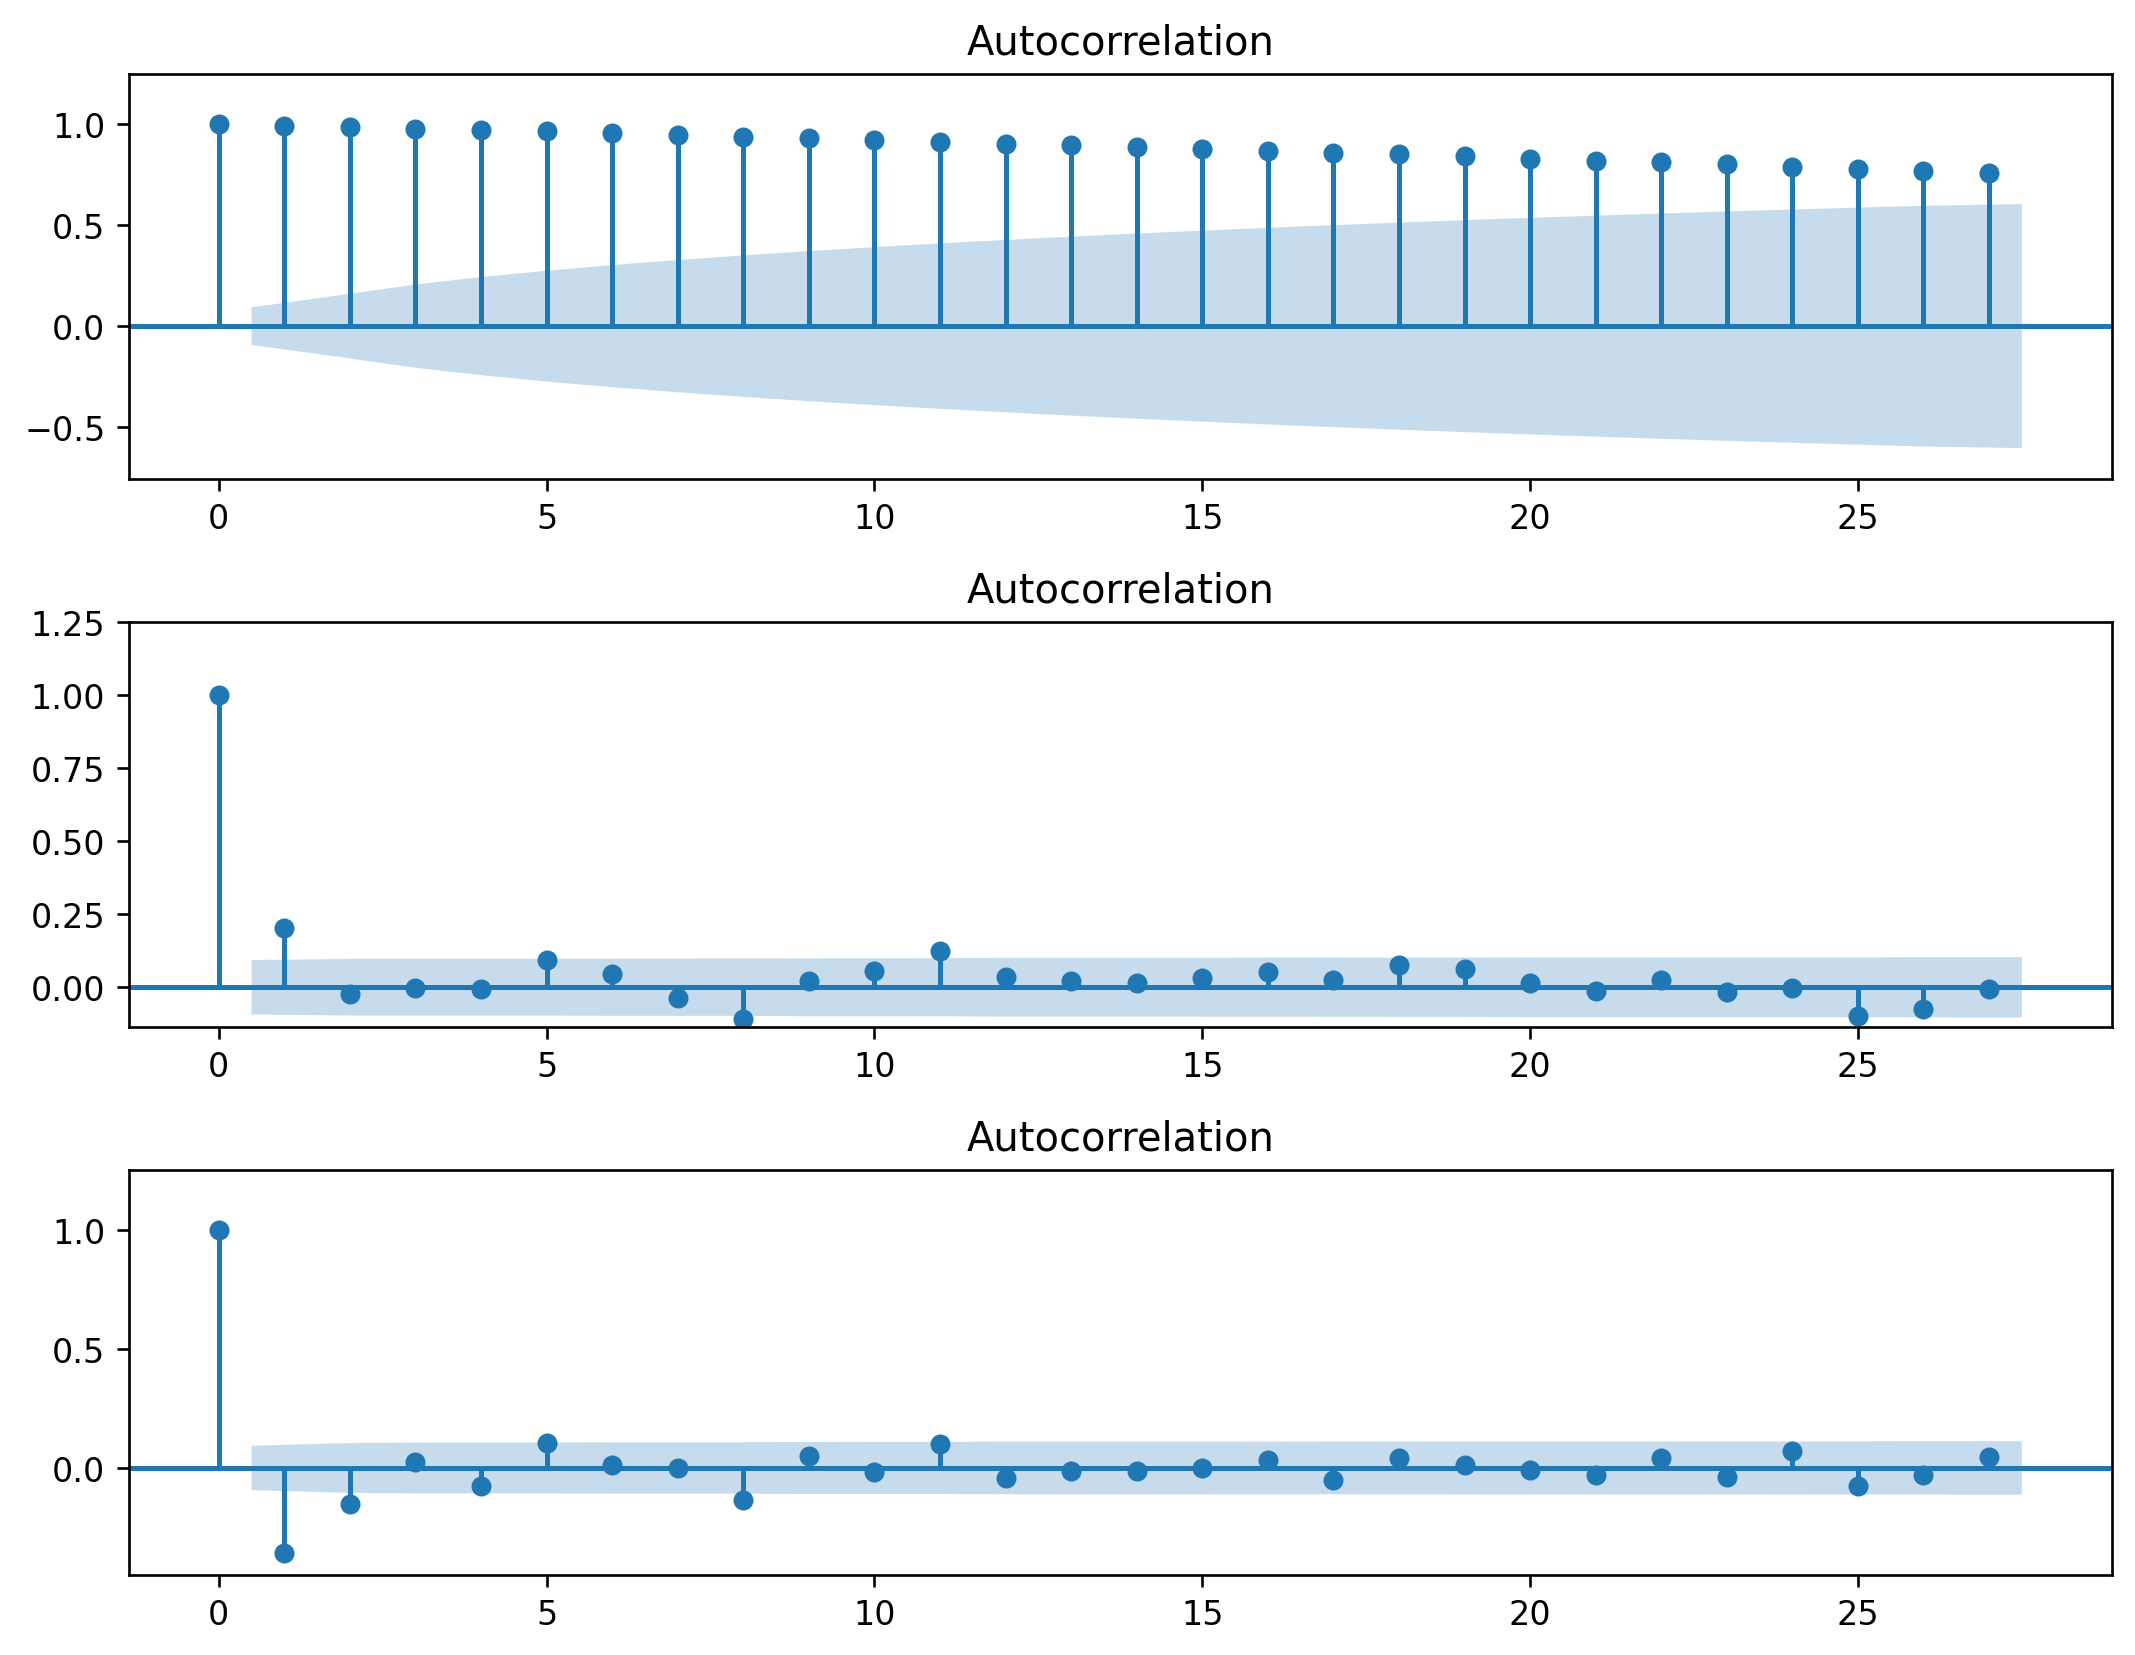

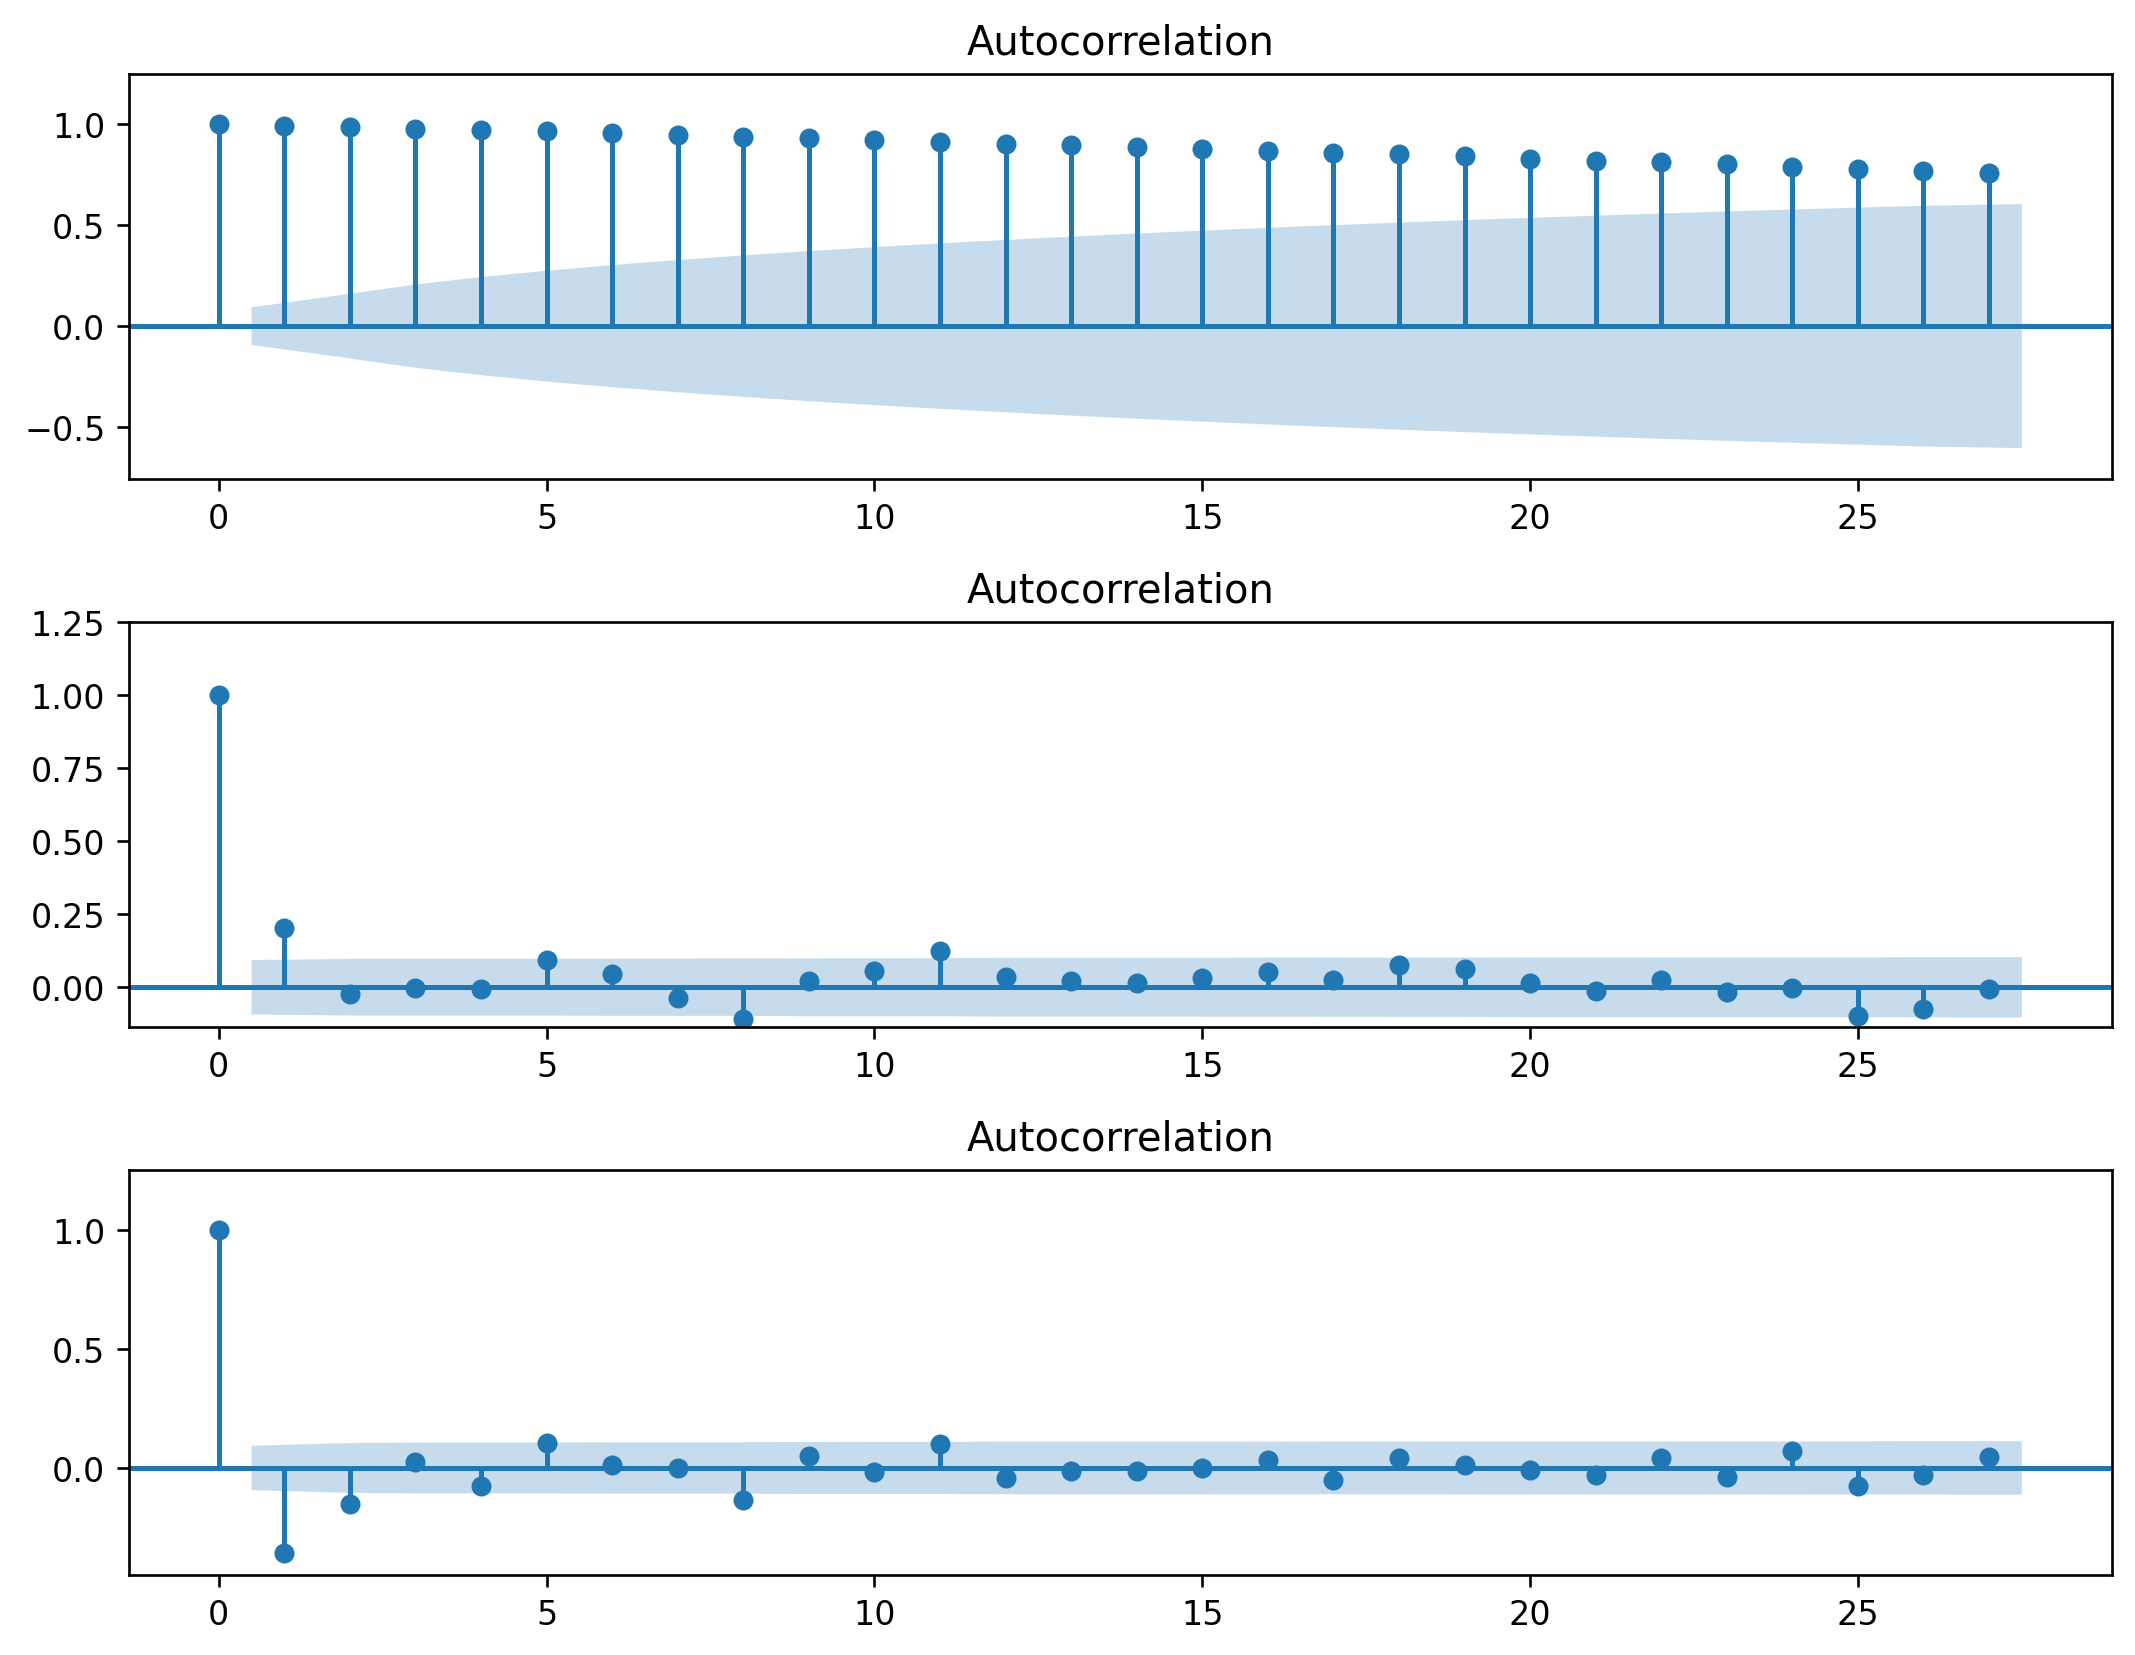

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
#lagval = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(y1, ax=ax1, alpha= 0.05, zero= True, auto_ylims= True)
plot_acf(yd1,ax=ax2, alpha= 0.05, zero = True, auto_ylims= True)
plot_acf(yd2, ax=ax3, alpha = 0.05, zero = True, auto_ylims= True)



### Plotting PACF

c:\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


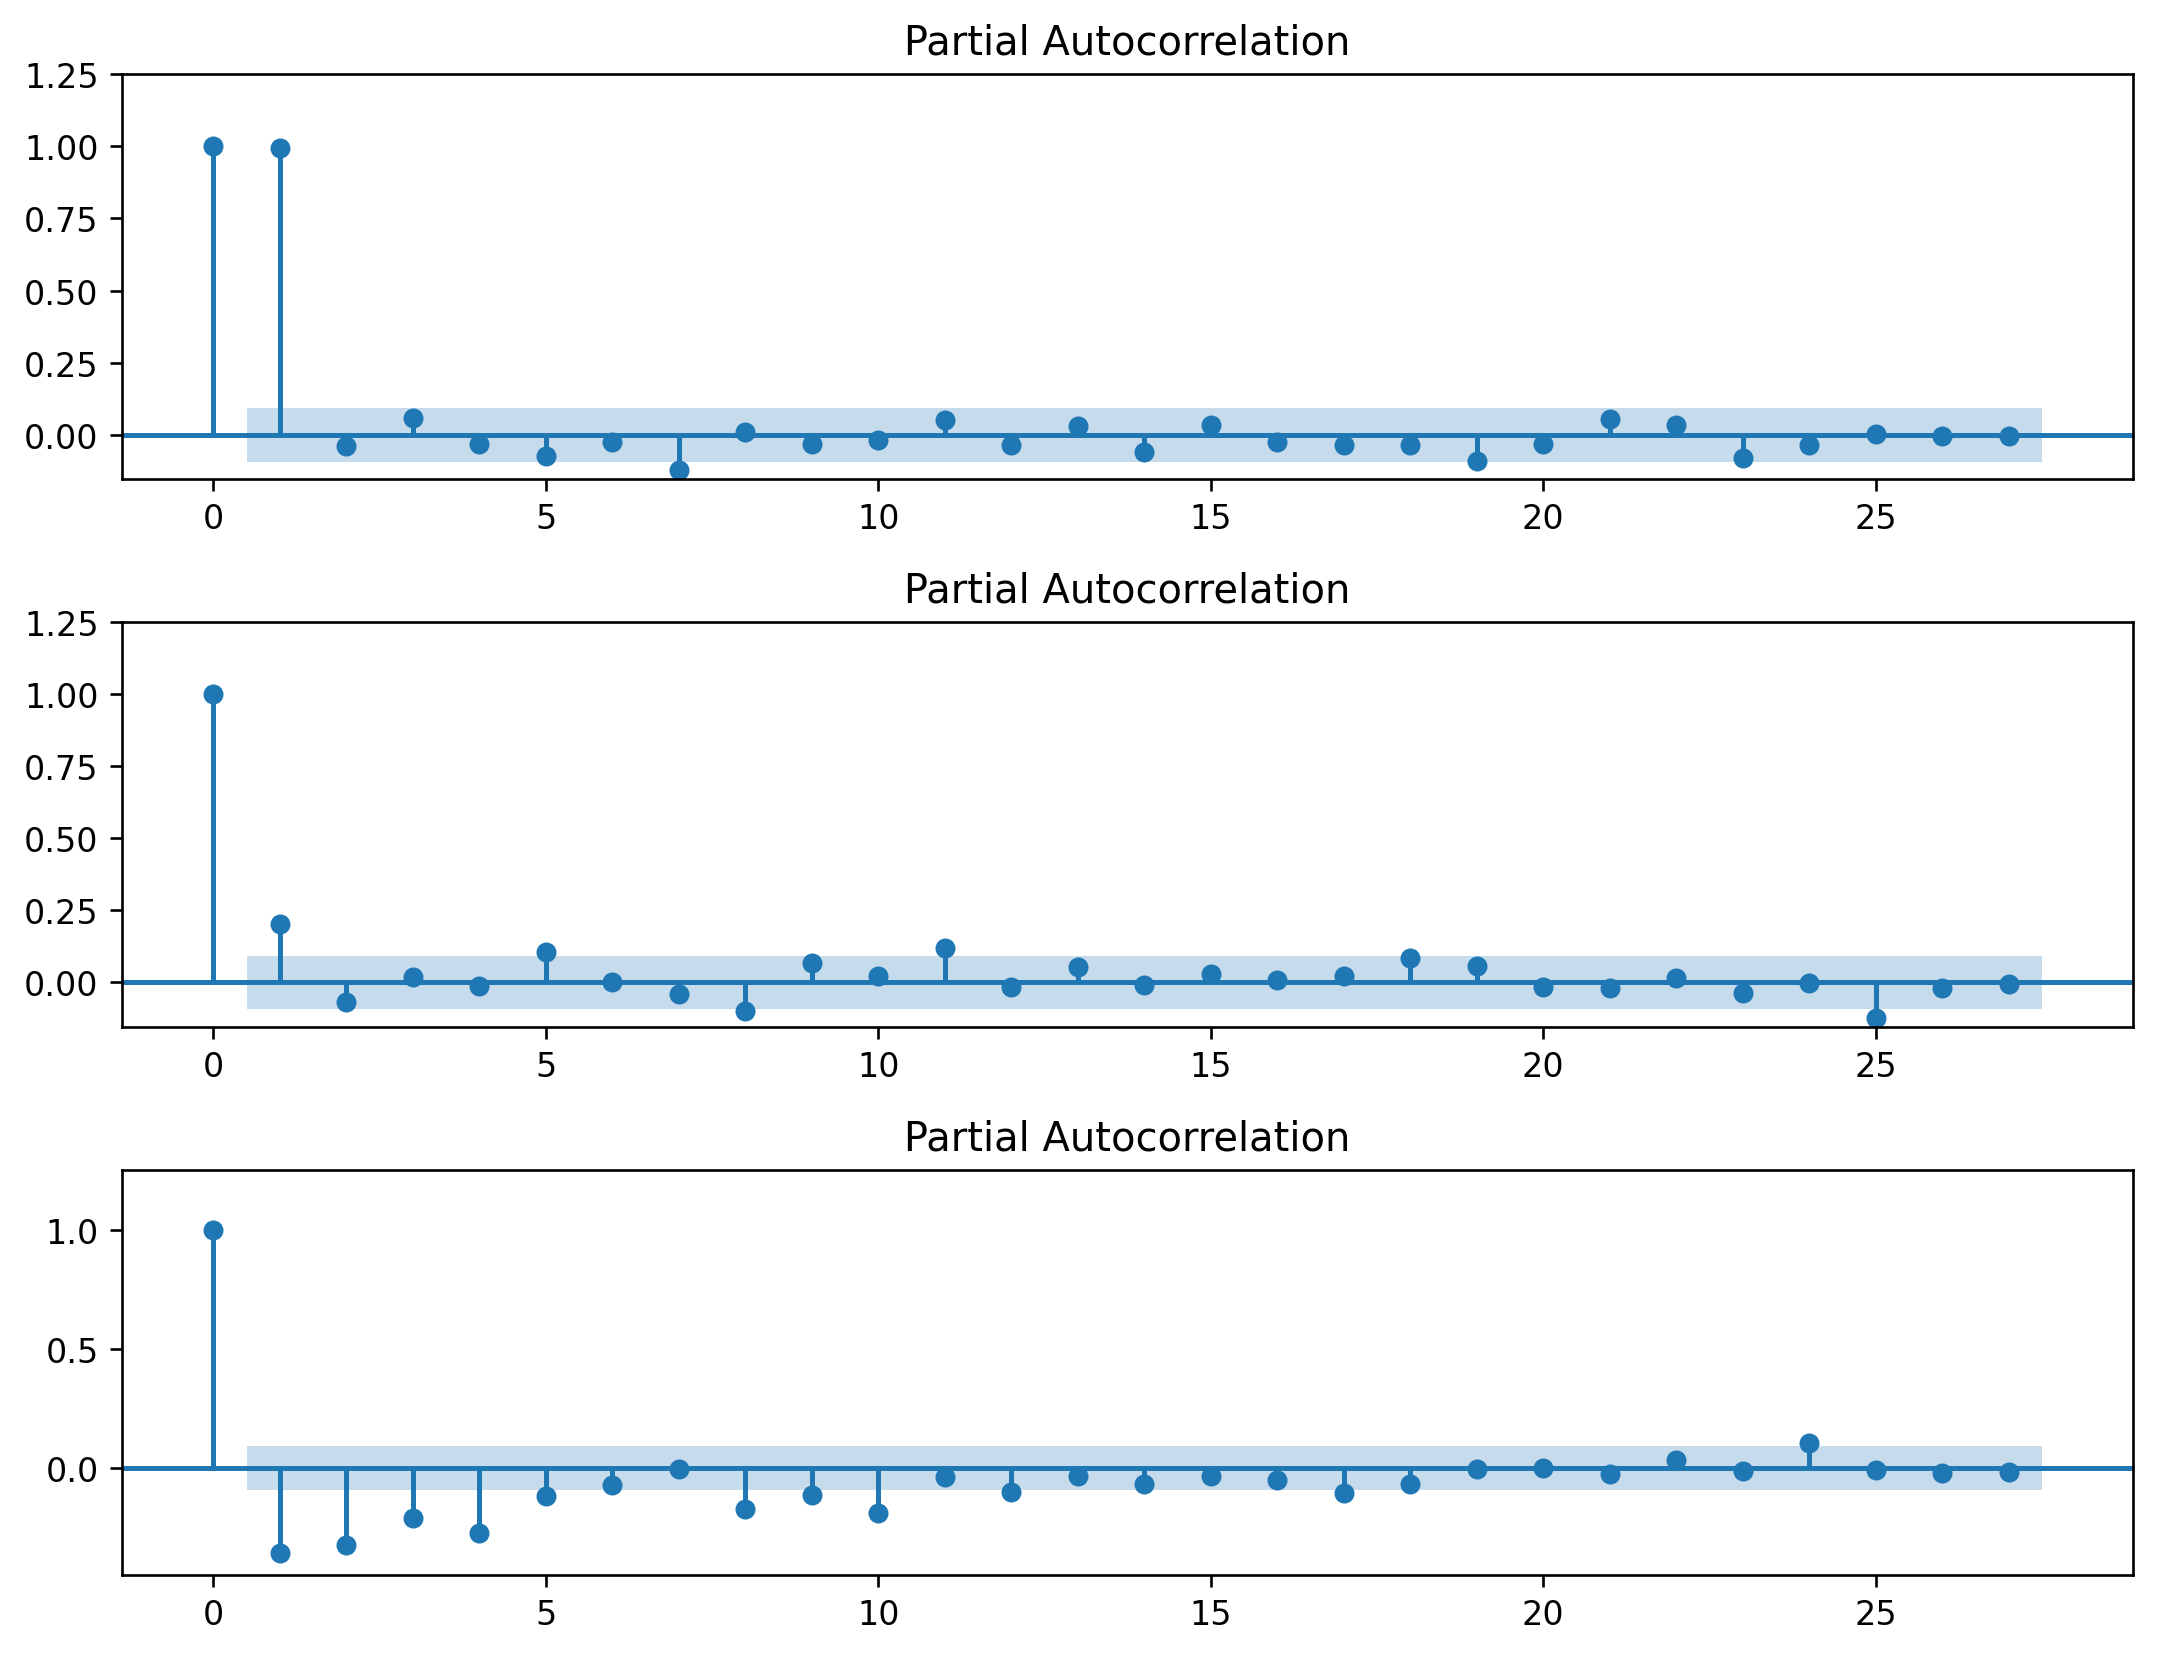

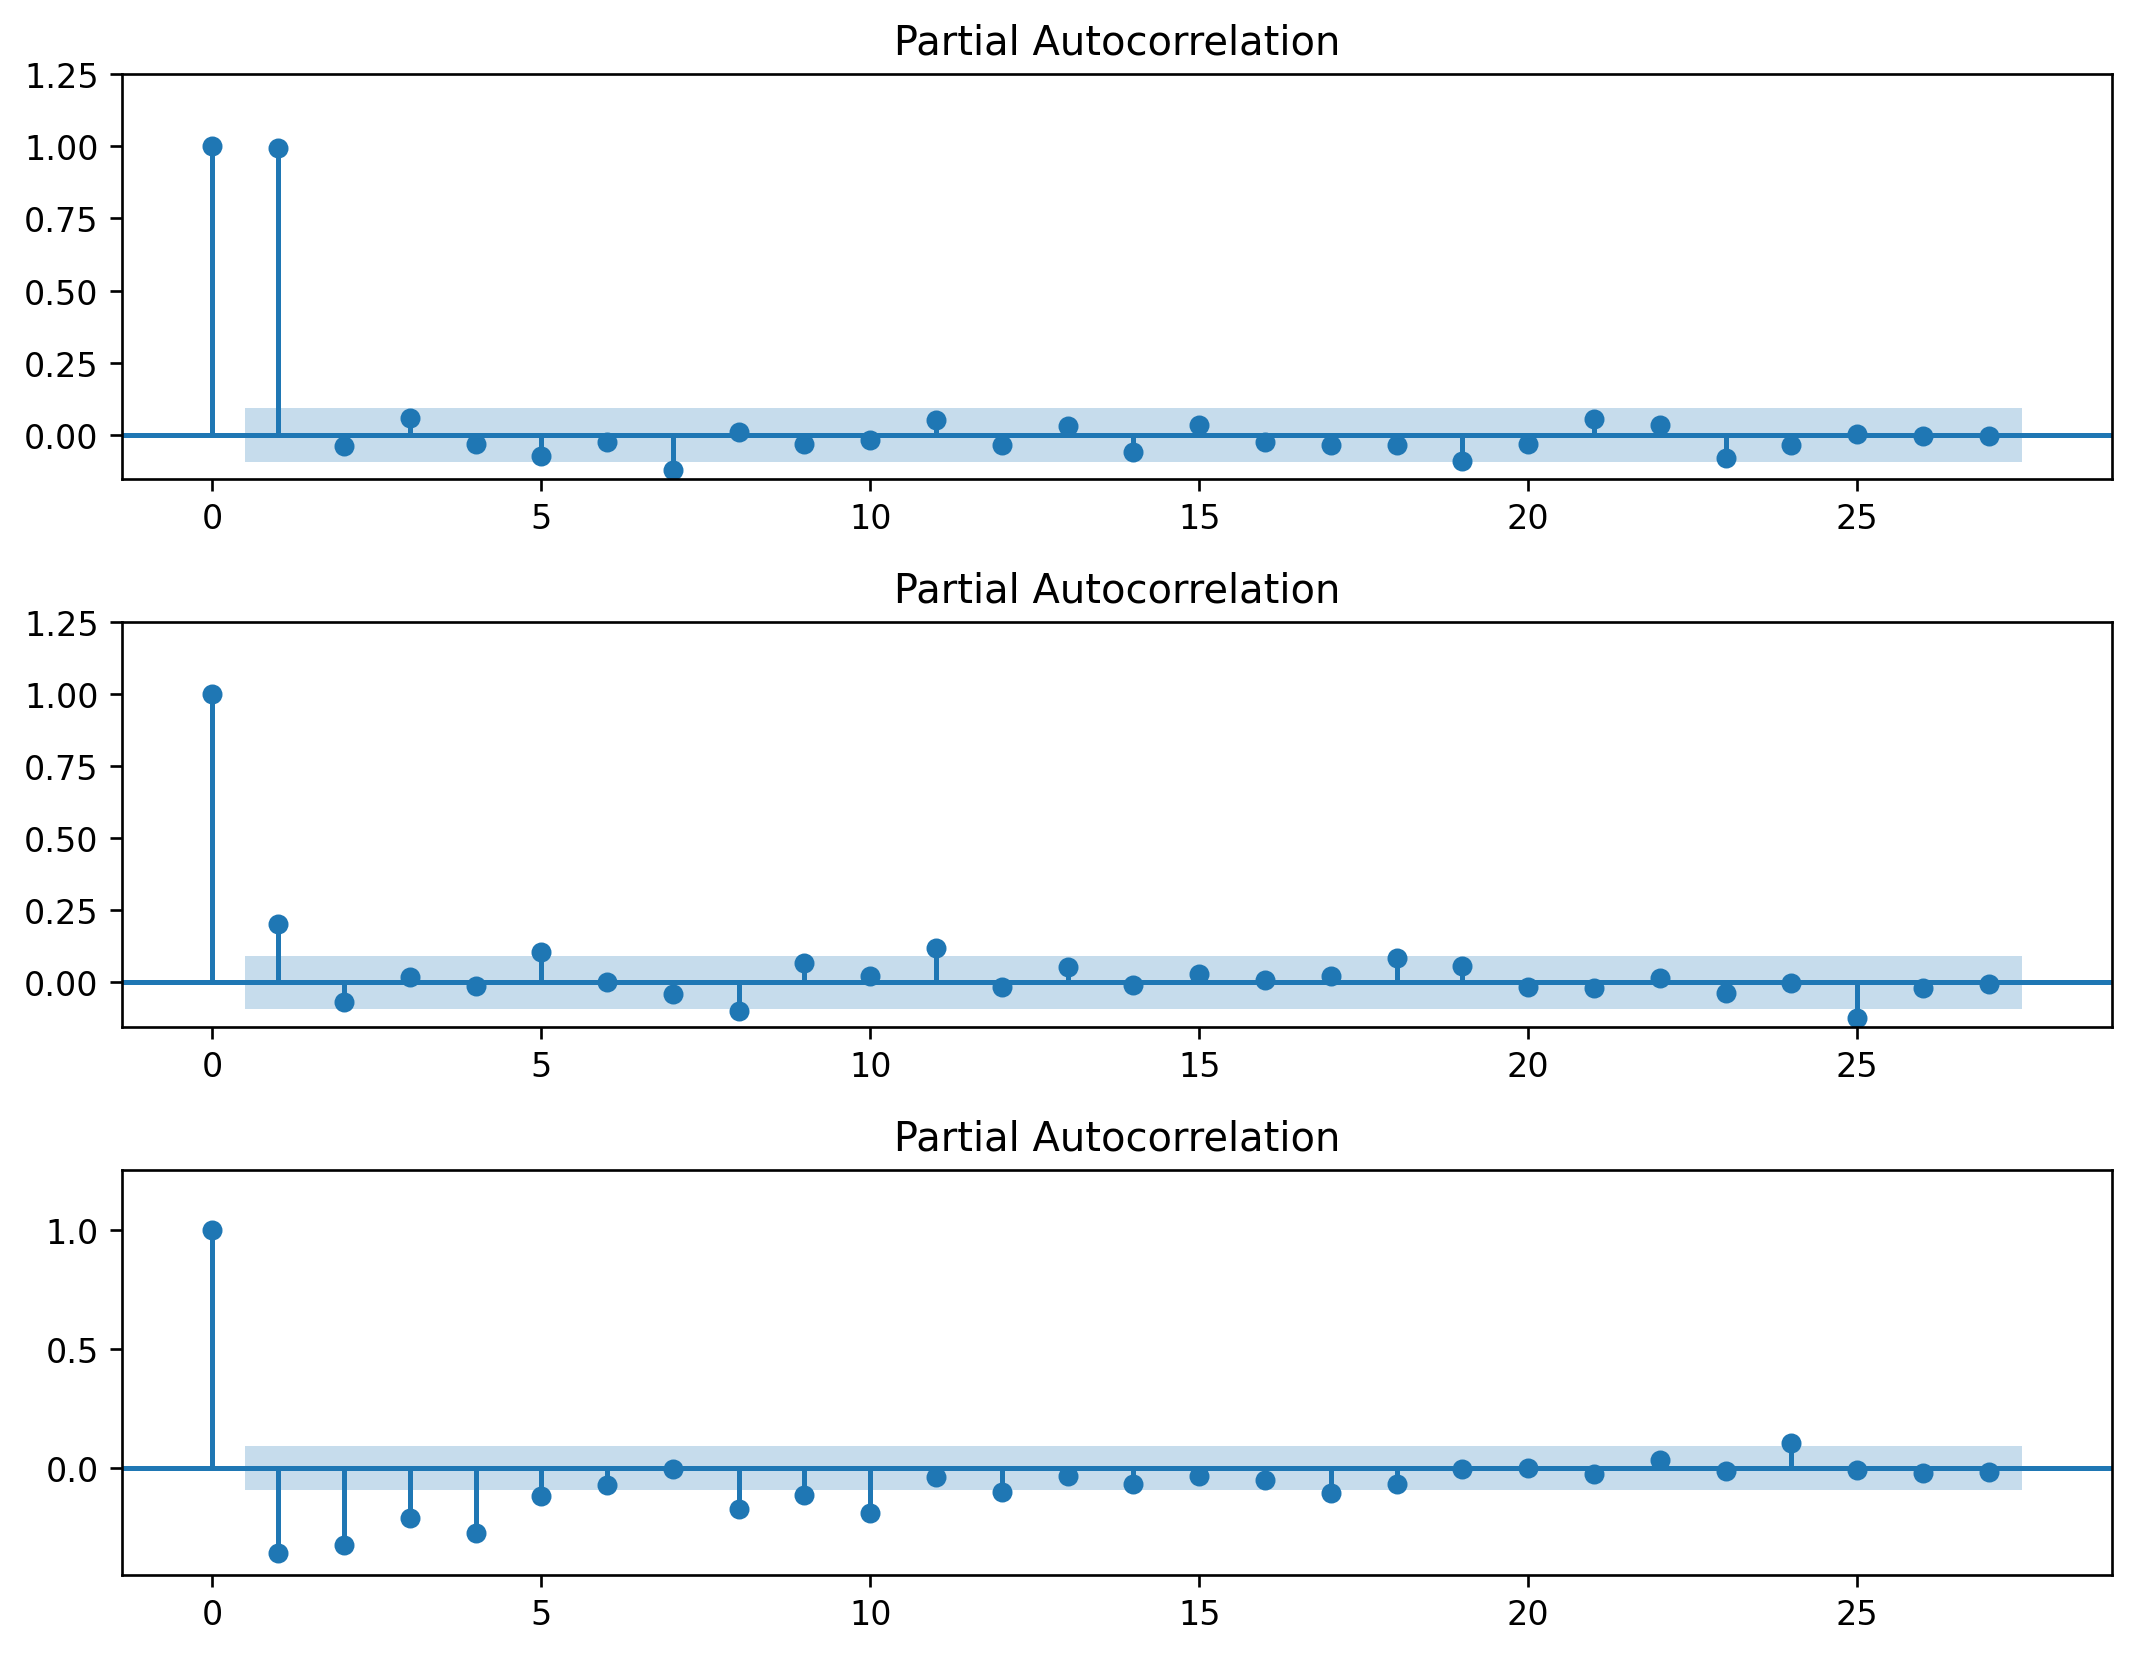

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_pacf(y1, ax=ax1, auto_ylims = True)
plot_pacf(yd1, ax=ax2, auto_ylims = True)
plot_pacf(yd2, ax=ax3, auto_ylims = True )

From the ACF and PACF plot, we can see that at  
d = 1 -> We cant determine the parameter <b> p</b> and <b> q </b> since we can't tell the cut off and decay of the plot  
d = 2 -> we can see at lag 1 ACF plot is <i> cut off </i> and <i> decay </i> then we can get <b> q = 1 </b> and <b> b = 0</b>  
  
Therfore the parameter we will use is <b>ARIMA(0,2,1)</b>

### Recheck Stationary if d = 1

In [15]:
from statsmodels.tsa.stattools import adfuller
# Null hypothesis: the model has unit root
resultadfd1 = adfuller(yd1)
print('Augmented Dickey Fuller Test at d = 2')
print('ADF Statistic: %f' % resultadfd1[0])
print('p-value: %f' % resultadfd1[1])
print('Critical Values:')
for key, value in resultadfd1[4].items():
  print('\t%s: %.3f' % (key, value))


Augmented Dickey Fuller Test at d = 2
ADF Statistic: -5.212569
p-value: 0.000008
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


In [16]:
from statsmodels.tsa.stattools import kpss
#  Null hypothesis: the dataset is stationary
resultkpssd1 = kpss(yd1)
print('At d = 2, Stationary KPSS Test result:')
print('KPSS Statistic: %f' % resultkpssd1[0])
print('p-value: %f' % resultkpssd1[1])
print('Lag: ', resultkpssd1[2])
for key, value in resultkpssd1[3].items():
  print('\t%s: %.3f' % (key, value))

At d = 2, Stationary KPSS Test result:
KPSS Statistic: 0.242312
p-value: 0.100000
Lag:  3
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


c:\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [17]:
stationary(0.05, resultadfd1[1], resultkpssd1[1])

The data is Stationary


Since the model becomes stationary at the <b> first order </b>. Therefore, we will use <b> d = 1 </b> to keep the model simple and we will not study stationary for higher difference.

## Training Model

In [18]:
#Training multiple model 
#ARIMA(0,0,0)
order = (0,1,2)
arima_model = ARIMA(y_train, order = order)
arima_fitting = arima_model.fit(low_memory= False, transformed= False, cov_type='robust_approx')
arima_fitting.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  360
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1713.269
Date:                Fri, 10 Feb 2023   AIC                           3432.537
Time:                        10:55:53   BIC                           3444.187
Sample:                             0   HQIC                          3437.170
                                - 360                                         
Covariance Type:        robust_approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2010      0.100      2.015      0.044       0.005       0.397
ma.L2         -0.0569      0.130     -0.437      0.662      -0.312       0.198
sigma2       817.8417    127.486      6.415      0.000     567.973    1067.710
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               678.03
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.67
===================================================================================

Warnings:
[1] Quasi-maximum likelihood covariance matrix used for robustness to some misspecifications; calculated using numerical (complex-step) differentiation.
"""

## Model Residual 

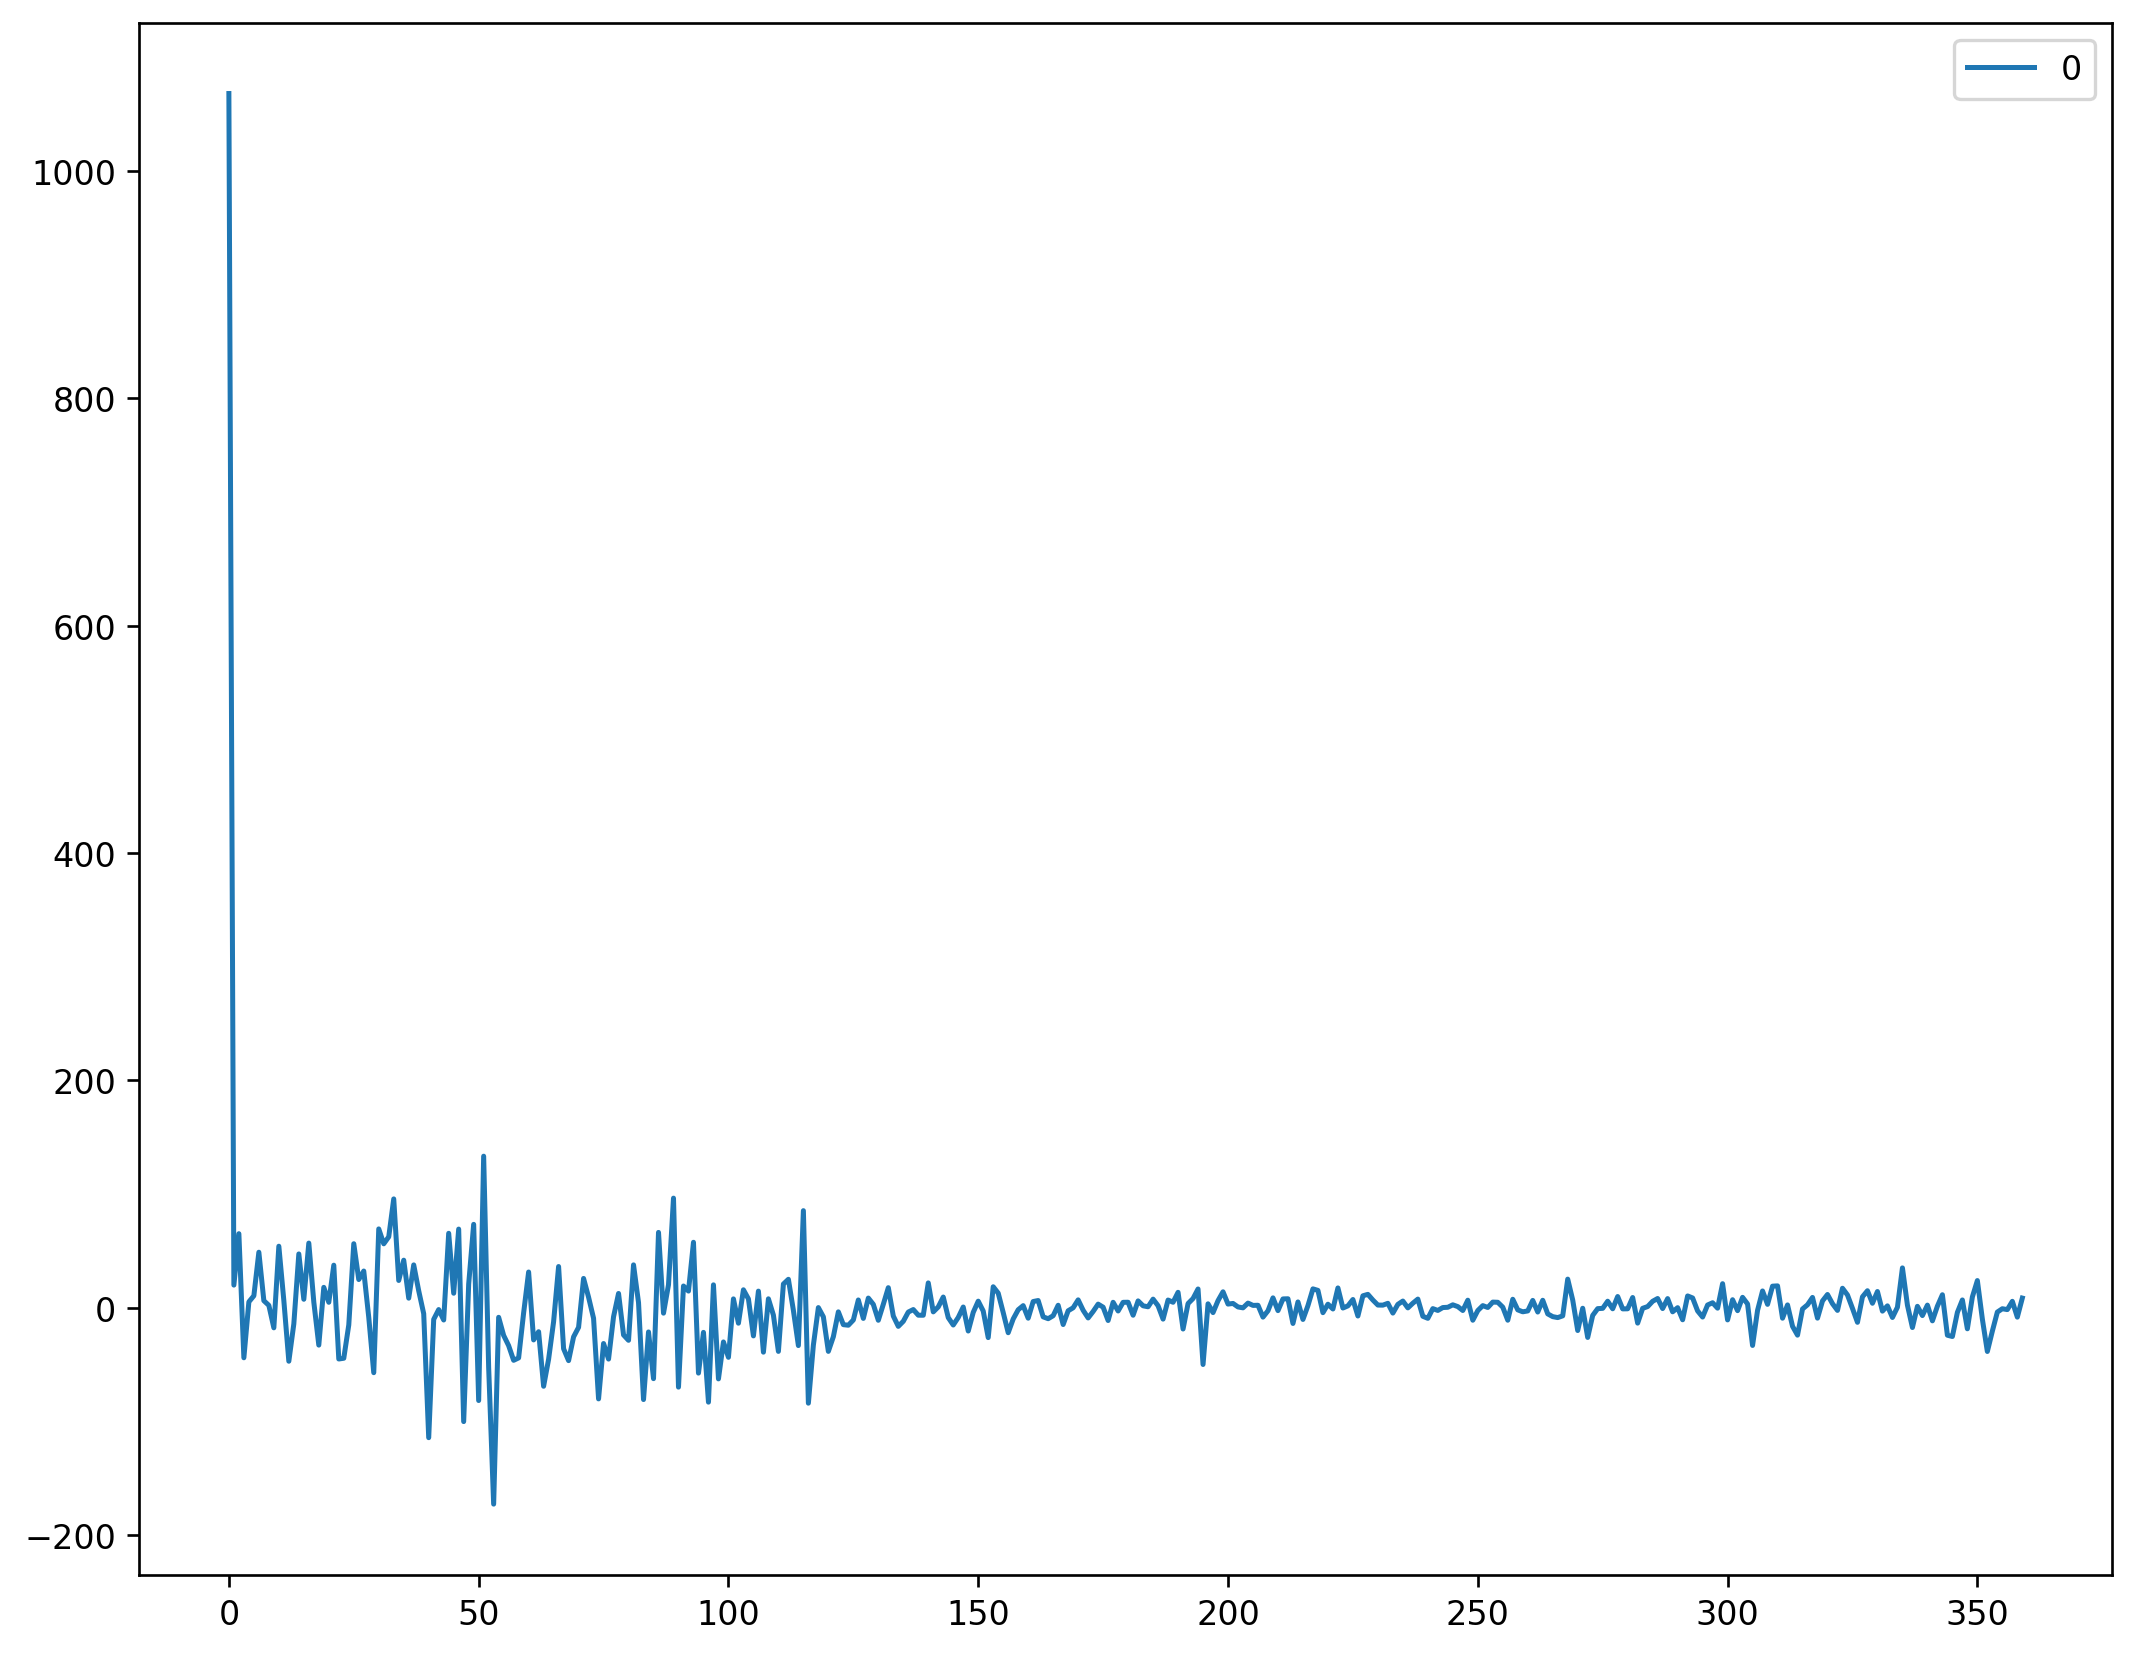

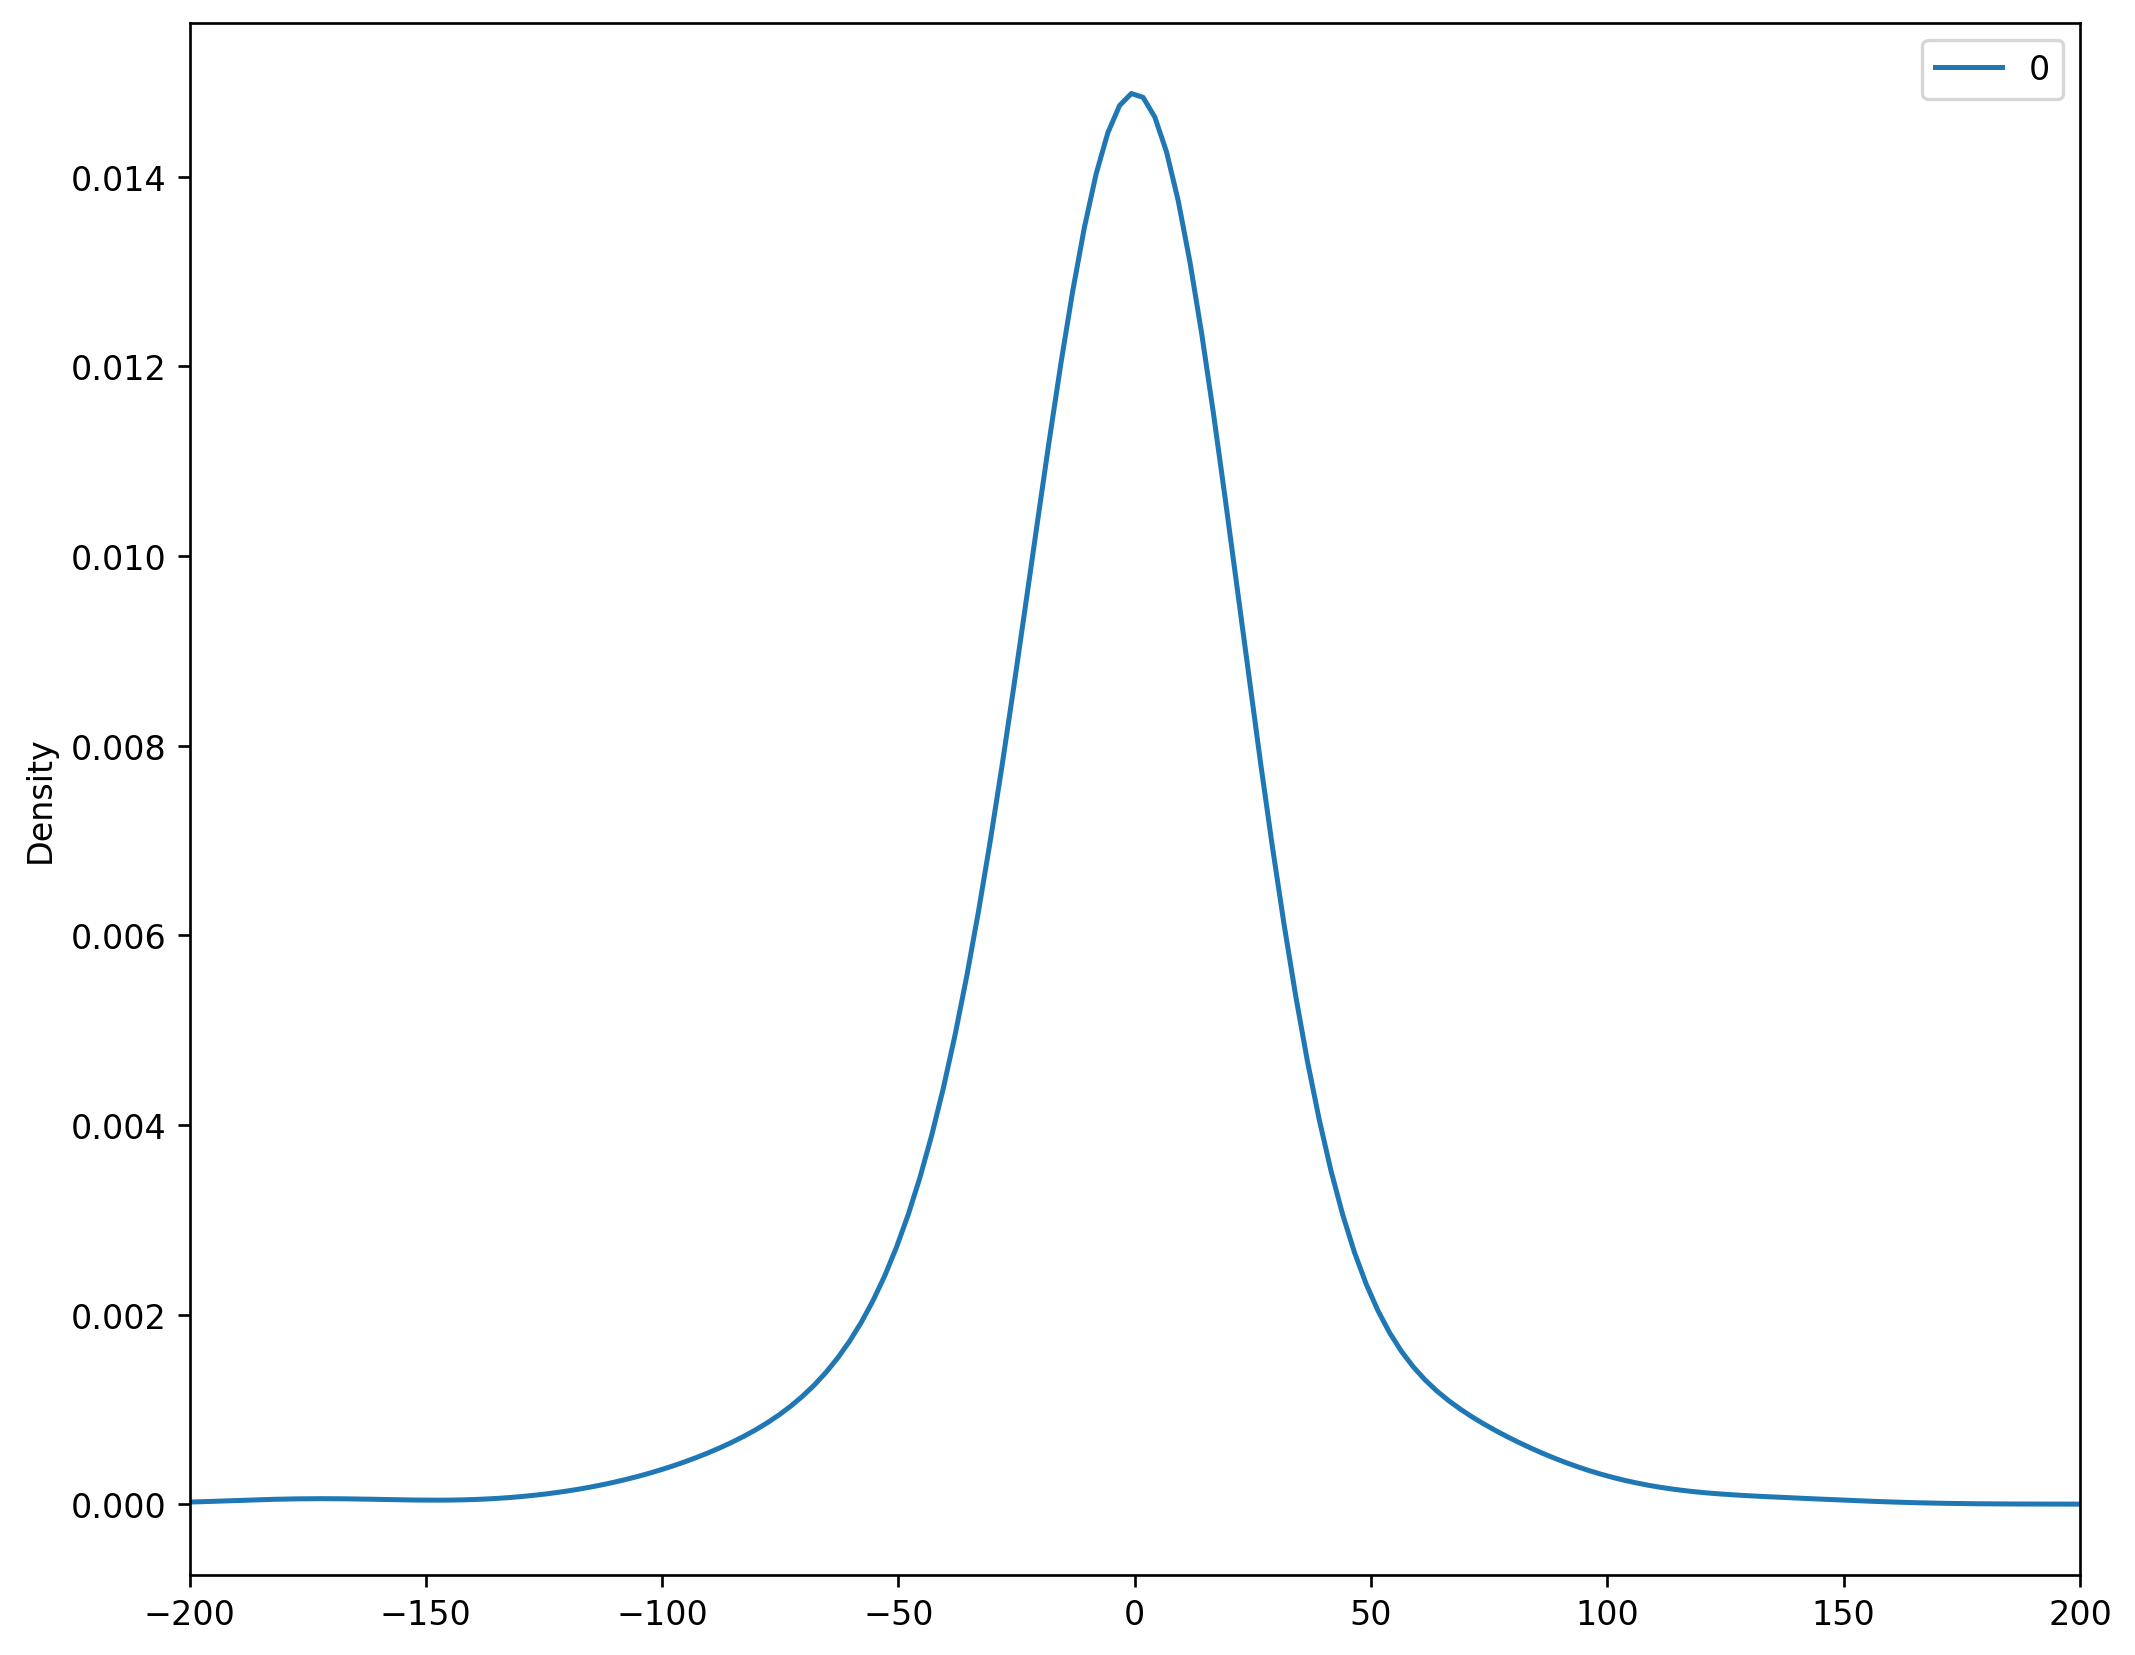

                 0
count   360.000000
mean      1.217734
std      63.210965
min    -172.801810
25%      -9.702867
50%       0.087671
75%       7.754055
max    1068.320000


In [19]:
residuals = DataFrame(arima_fitting.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.xlim([-200,200])
plt.show()
# summary stats of residuals
print(residuals.describe())

## Predicting Model

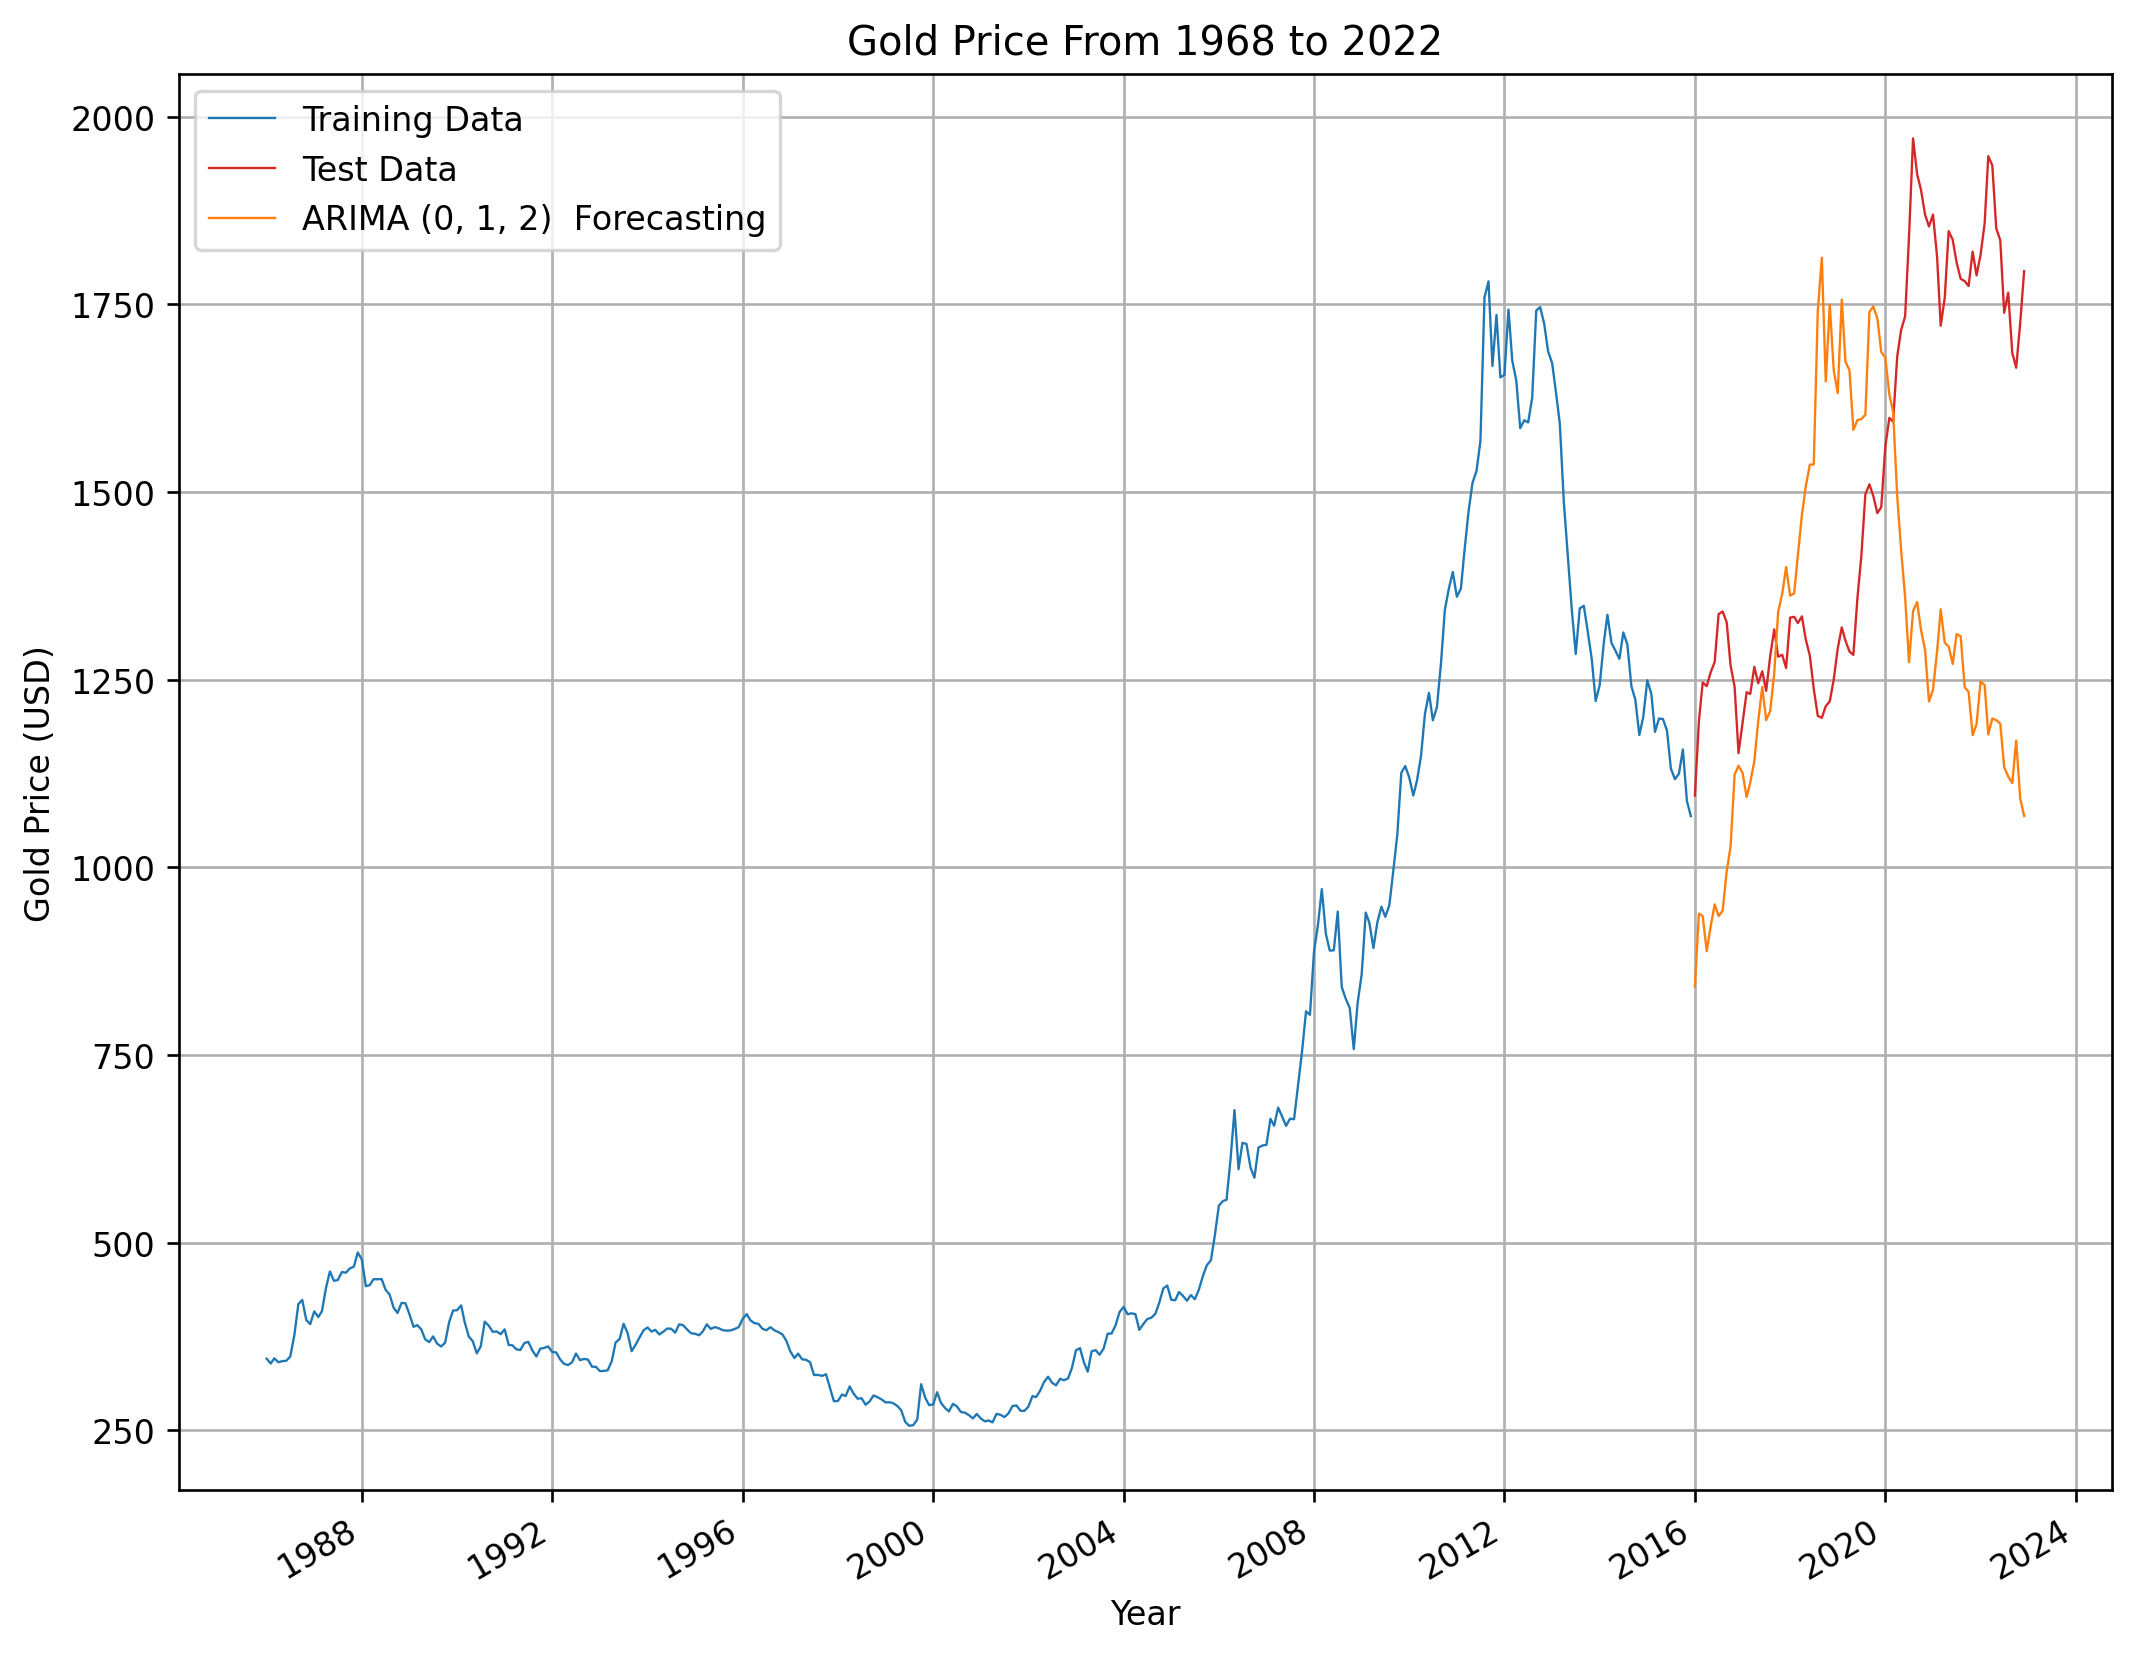

In [20]:
pred_start_date = x[0]
pred_end_date = x[-1]
index = len(x)-len(x_train)
pred_val = arima_fitting.predict(1, index)
#index = len(x)
plt.grid()

plt.rcParams["figure.figsize"] = [7.50, 5.0]
plt.rcParams['figure.dpi'] = 800
plt.rcParams["figure.autolayout"] = True
plt.xticks(rotation=30, ha='right')
plt.plot(x_train, y_train, color = 'C0', label = 'Training Data', linewidth = 0.7 )
plt.plot(x_test, y_test, color = 'C3', label = 'Test Data', linewidth = 0.7)
plt.plot(x_test, pred_val,color = 'C1', label = 'ARIMA '+ str(order)+'  Forecasting',  linewidth = 0.7)
plt.title('Gold Price From 1968 to 2022')
plt.xlabel('Year')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.show()

## Evaluate Result

In [24]:
print(pred_val.shape)
y_test = y_test.reshape(-1)
print(y_test.shape)
evaluate(pred_val, y_test)


(84,)
(84,)
Root Mean Squre error (RMSE)= 416.181811 
Mean Absolute Square Error (MAPE) = 0.226325
Symmetric Mean Absolute Square Error (sMAPE) = 0.246267
